# Cálculo de la factura eléctrica

- Recuperación de datos de consumo eléctrico horario del medidor de consumo ([enerPI]()) vía JSON.
Para otros casos, formar un `pandas.Series` de índice horario con datos de consumo en kWh.
- Generación de factura eléctrica mediante `esiosdata.FacturaElec`
- Simulación de cambio de tarifa eléctrica para el mismo consumo
- Alguna gráfica de los patrones de consumo diario

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from glob import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
from esiosdata import FacturaElec
from esiosdata.prettyprinting import *


# enerPI JSON API
ip_enerpi = '192.168.1.44'
t0, tf = '2016-11-01', '2016-12-24'
url = 'http://{}/enerpi/api/consumption/from/{}/to/{}'.format(ip_enerpi, t0, tf)
print(url)
r = requests.get(url)
if r.ok:
    data = r.json()
    data_consumo = pd.DataFrame(pd.Series(data, name='kWh')).sort_index().reset_index()
    data_consumo.index = data_consumo['index'].apply(lambda x: pd.Timestamp.fromtimestamp(float(x) / 1000.))
    data_consumo.drop('index', axis=1, inplace=True)
    print_ok(data_consumo.head())
    print_ok(data_consumo.tail())
else:
    print_err(r)

http://192.168.1.44/enerpi/api/consumption/from/2016-11-01/to/2016-12-24
                        kWh
index                      
2016-11-01 00:00:00  0.3179
2016-11-01 01:00:00  0.2329
2016-11-01 02:00:00  0.2317
2016-11-01 03:00:00  0.2343
2016-11-01 04:00:00  0.2242
                        kWh
index                      
2016-12-24 19:00:00  0.3294
2016-12-24 20:00:00  0.5632
2016-12-24 21:00:00  0.4405
2016-12-24 22:00:00  0.2757
2016-12-24 23:00:00  0.2938


517.615


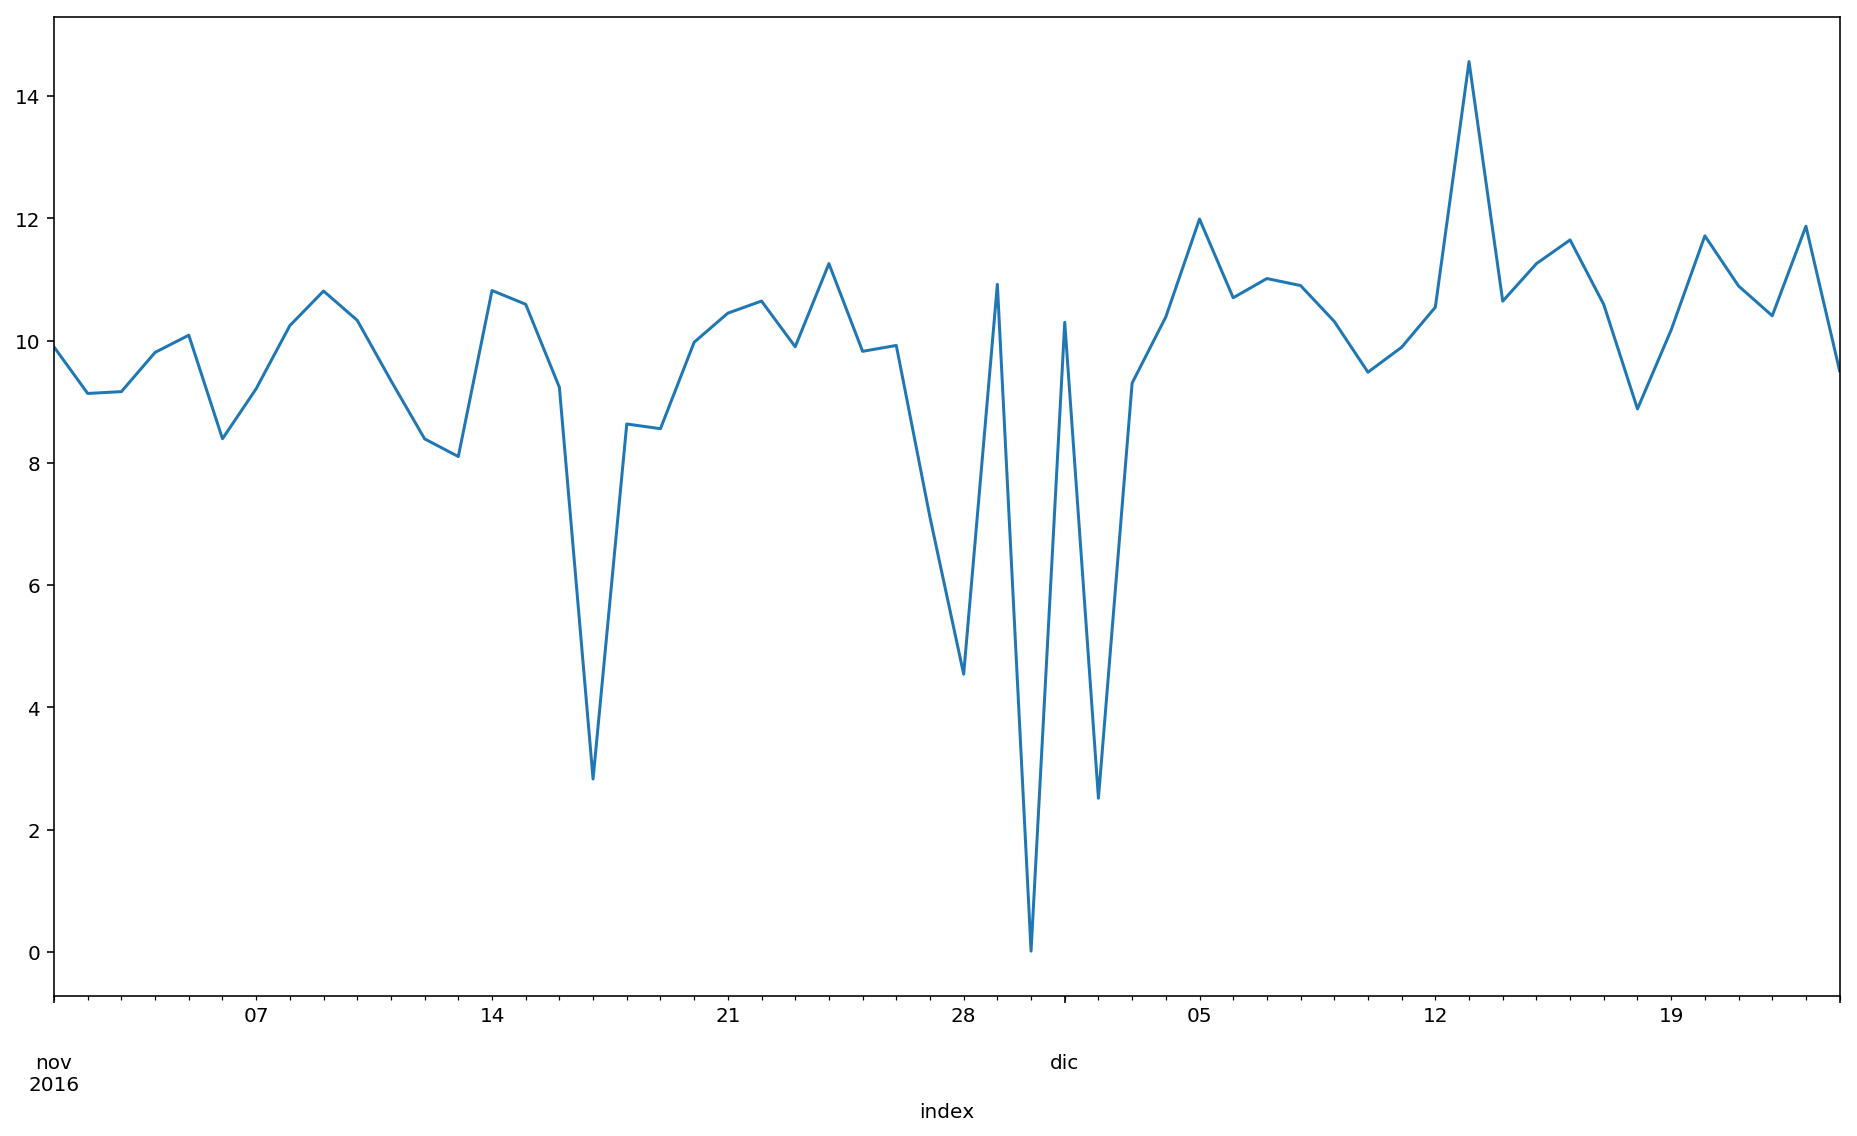

In [2]:
# Consumo Total en intervalo:
c_tot = round(data_consumo.kWh.round(3).sum(), 3)
print_ok(c_tot)

# Plot consumo diario en kWh
data_consumo.kWh.resample('D').sum().plot(figsize=(16, 9));

## Factura eléctrica con datos horarios

In [3]:
factura = FacturaElec(consumo=data_consumo.kWh)
print_info(factura)

Asignando timezone a consumo horario: Europe/Madrid
FACTURA ELÉCTRICA:
--------------------------------------------------------------------------------
* Fecha inicio             	31/10/2016
* Fecha final              	24/12/2016
* Peaje de acceso          	2.0A (General)
* Potencia contratada      	3.45 kW
* Consumo periodo          	517.61 kWh
* ¿Bono Social?            	No
* Equipo de medida         	1.43 €
* Impuestos                	Península y Baleares (IVA)
* Días facturables         	54
--------------------------------------------------------------------------------

- CÁLCULO DEL TÉRMINO FIJO POR POTENCIA CONTRATADA:
    3.45 kW * 42.043426 €/kW/año * 54 días (2016) / 366 = 21.40 €
     -> Término fijo                                                   21.40 €

- CÁLCULO DEL TÉRMINO VARIABLE POR ENERGÍA CONSUMIDA (TARIFA 2.0A):
    Periodo 1: 0.125777 €/kWh                          -> 65.10€(P1)
    - Peaje de acceso: 518kWh * 0.044027€/kWh = 22.79€
    - Coste de la energía: 5

In [4]:
factura.tipo_peaje = 2
print_cyan(factura)

FACTURA ELÉCTRICA:
--------------------------------------------------------------------------------
* Fecha inicio             	31/10/2016
* Fecha final              	24/12/2016
* Peaje de acceso          	2.0DHA (Nocturna)
* Potencia contratada      	3.45 kW
* Consumo periodo          	517.61 kWh
* ¿Bono Social?            	No
* Equipo de medida         	1.43 €
* Impuestos                	Península y Baleares (IVA)
* Días facturables         	54
--------------------------------------------------------------------------------

- CÁLCULO DEL TÉRMINO FIJO POR POTENCIA CONTRATADA:
    3.45 kW * 42.043426 €/kW/año * 54 días (2016) / 366 = 21.40 €
     -> Término fijo                                                   21.40 €

- CÁLCULO DEL TÉRMINO VARIABLE POR ENERGÍA CONSUMIDA (TARIFA 2.0DHA):
    Periodo 1: 0.147546 €/kWh                          -> 38.45€(P1)
    - Peaje de acceso: 261kWh * 0.062012€/kWh = 16.16€
    - Coste de la energía: 261kWh * 0.085534€/kWh = 22.29€
    Periodo 2: 0

In [5]:
factura.tipo_peaje = 3
print_magenta(factura)

FACTURA ELÉCTRICA:
--------------------------------------------------------------------------------
* Fecha inicio             	31/10/2016
* Fecha final              	24/12/2016
* Peaje de acceso          	2.0DHS (Vehículo eléctrico)
* Potencia contratada      	3.45 kW
* Consumo periodo          	517.61 kWh
* ¿Bono Social?            	No
* Equipo de medida         	1.43 €
* Impuestos                	Península y Baleares (IVA)
* Días facturables         	54
--------------------------------------------------------------------------------

- CÁLCULO DEL TÉRMINO FIJO POR POTENCIA CONTRATADA:
    3.45 kW * 42.043426 €/kW/año * 54 días (2016) / 366 = 21.40 €
     -> Término fijo                                                   21.40 €

- CÁLCULO DEL TÉRMINO VARIABLE POR ENERGÍA CONSUMIDA (TARIFA 2.0DHS):
    Periodo 1: 0.148466 €/kWh                          -> 39.89€(P1)
    - Peaje de acceso: 269kWh * 0.062012€/kWh = 16.66€
    - Coste de la energía: 269kWh * 0.086454€/kWh = 23.23€
    Pe

### EXPORT TO CSV

* Para importar en https://facturaluz2.cnmc.es/facturaluz2.html

In [6]:
path_csv = os.path.expanduser('~/Desktop/')
df_csv = factura.generacion_csv_oficial_consumo_horario(path_csv)
print_ok(df_csv.tail())
file_path = glob(path_csv + '*.csv')[0]
with open(file_path, 'r') as f:
    print_magenta(f.read()[:500])

                                           CUPS       Fecha  Hora  Consumo_kWh Metodo_obtencion
index                                                                                          
2016-12-24 19:00:00+01:00  ES00XXXXXXXXXXXXXXDB  24/12/2016    20        0.329                R
2016-12-24 20:00:00+01:00  ES00XXXXXXXXXXXXXXDB  24/12/2016    21        0.563                R
2016-12-24 21:00:00+01:00  ES00XXXXXXXXXXXXXXDB  24/12/2016    22        0.440                R
2016-12-24 22:00:00+01:00  ES00XXXXXXXXXXXXXXDB  24/12/2016    23        0.276                R
2016-12-24 23:00:00+01:00  ES00XXXXXXXXXXXXXXDB  24/12/2016    24        0.294                R
CUPS;Fecha;Hora;Consumo_kWh;Metodo_obtencion
ES00XXXXXXXXXXXXXXDB;01/11/2016;1;0,318;R
ES00XXXXXXXXXXXXXXDB;01/11/2016;2;0,233;R
ES00XXXXXXXXXXXXXXDB;01/11/2016;3;0,232;R
ES00XXXXXXXXXXXXXXDB;01/11/2016;4;0,234;R
ES00XXXXXXXXXXXXXXDB;01/11/2016;5;0,224;R
ES00XXXXXXXXXXXXXXDB;01/11/2016;6;0,235;R
ES00XXXXXXXXXXXXXXDB;01/11/2016

### Plots del periodo facturado

Consumo diario


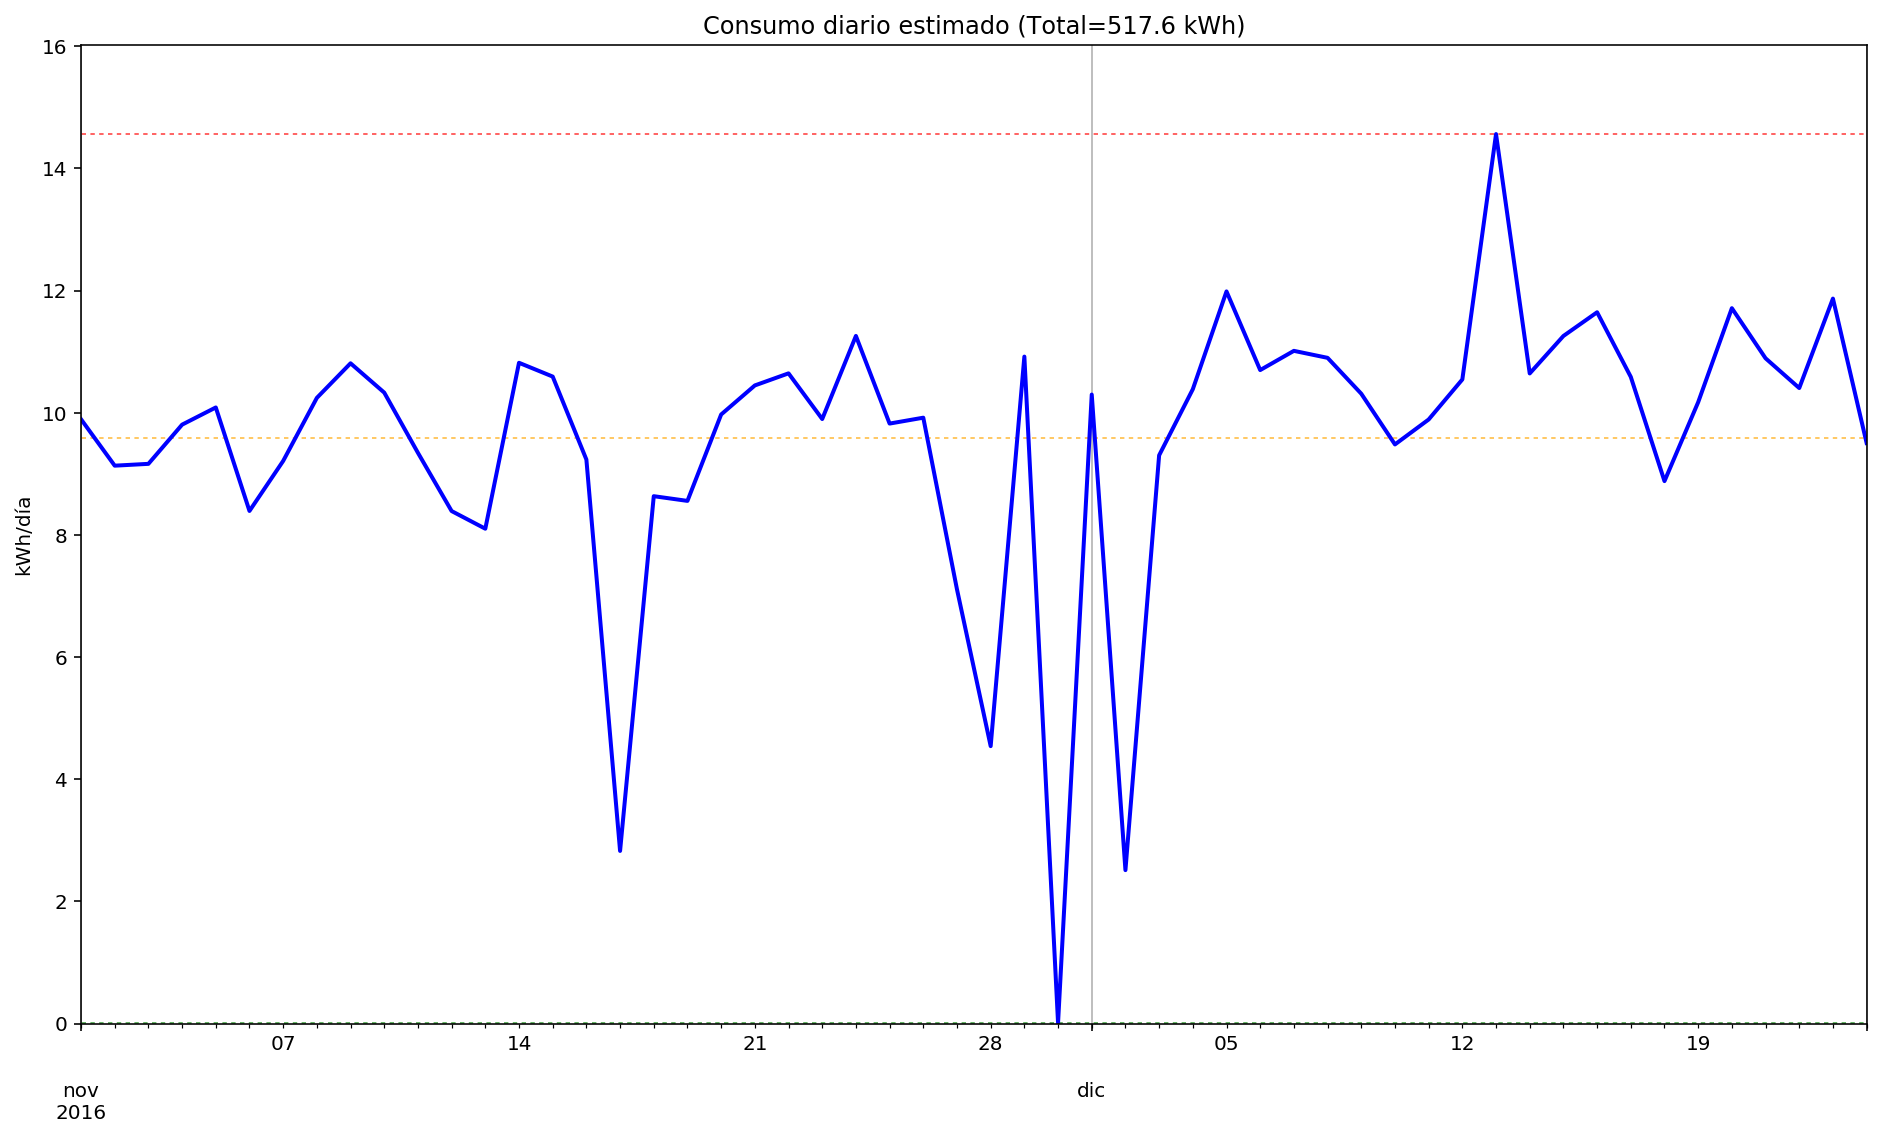

In [7]:
print_ok('Consumo diario')
factura.plot_consumo_diario()
plt.show()

Patrón de consumo semanal


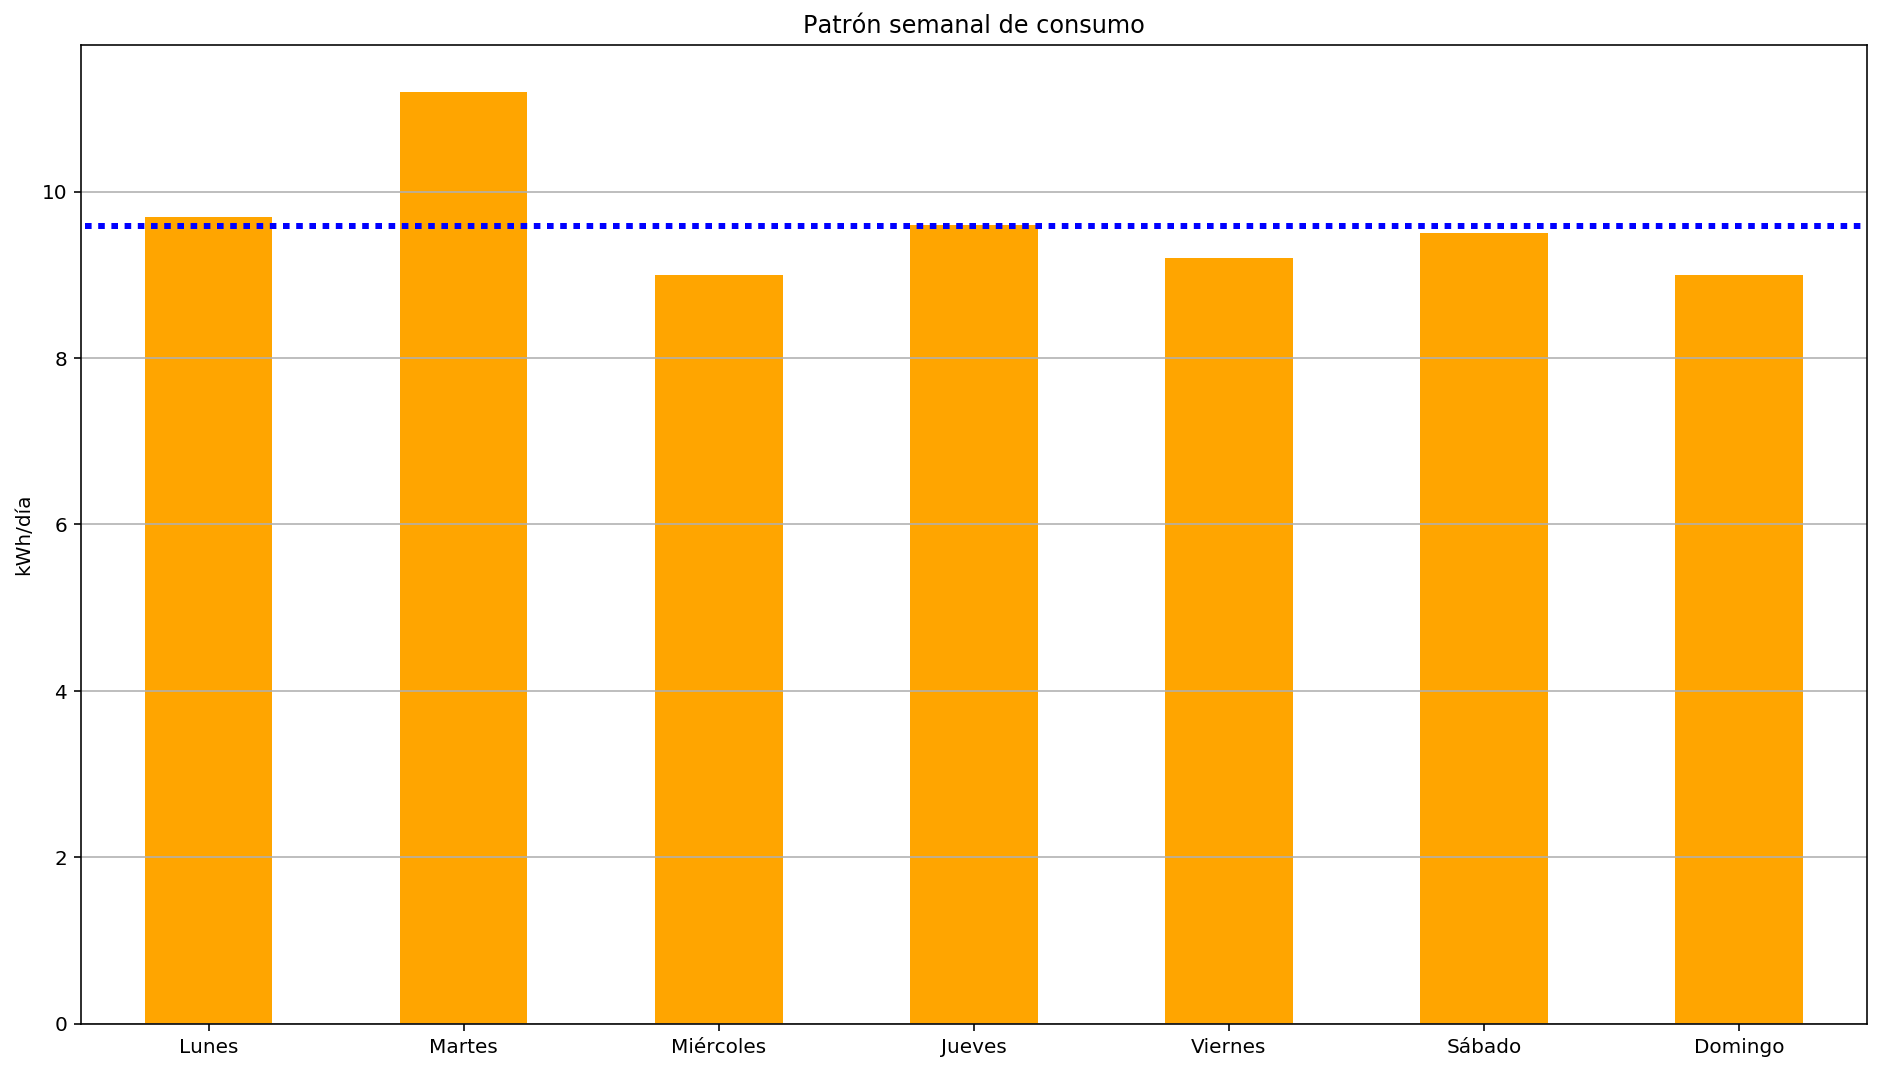

In [8]:
print_ok('Patrón de consumo semanal')
factura.plot_patron_semanal_consumo()
plt.show()